# Dataset analysis

In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport


warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [5]:
df = pd.read_csv("../data/songs.csv")

In [3]:
profile = ProfileReport(df, title="DataFrame info")
profile.to_file("raport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [525]:
df.head(4)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.251,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.347,0.544,119.992,"rock, metal"


In [526]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [527]:
df.nunique()

artist               835
song                1879
duration_ms         1793
explicit               2
year                  23
popularity            76
danceability         565
energy               580
key                   12
loudness            1671
mode                   2
speechiness          837
acousticness        1208
instrumentalness     772
liveness             783
valence              760
tempo               1831
genre                 59
dtype: int64

# Preprocessing part

### Changing the types

mode: `int` $\rightarrow$ `bool` (only 2 values)

key: `int` $\rightarrow$ `category` (12 values, but not of numeric character)

## Are there any duplicates?

In [6]:
df.duplicated().any() # yes, how many?

True

In [7]:
df.duplicated().sum() # this many

59

In [8]:
df[(df.duplicated(keep=False)) & (df["artist"] == "Linkin Park")] # example

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
20,Linkin Park,In the End,216880,False,2000,83,0.556,0.864,3,-5.87,0,0.0584,0.00958,0.0,0.209,0.4,105.143,"rock, metal"
215,Linkin Park,In the End,216880,False,2000,83,0.556,0.864,3,-5.87,0,0.0584,0.00958,0.0,0.209,0.4,105.143,"rock, metal"


## What about the genre?

In [9]:
genres = df.genre

In [10]:
genres.unique()

array(['pop', 'rock, pop', 'pop, country', 'rock, metal',
       'hip hop, pop, R&B', 'hip hop', 'pop, rock', 'pop, R&B',
       'Dance/Electronic', 'pop, Dance/Electronic',
       'rock, Folk/Acoustic, easy listening', 'metal', 'hip hop, pop',
       'R&B', 'pop, latin', 'Folk/Acoustic, rock',
       'pop, easy listening, Dance/Electronic', 'rock',
       'rock, blues, latin', 'pop, rock, metal', 'rock, pop, metal',
       'hip hop, R&B', 'pop, Folk/Acoustic', 'set()',
       'hip hop, pop, latin', 'hip hop, Dance/Electronic',
       'hip hop, pop, rock', 'World/Traditional, Folk/Acoustic',
       'Folk/Acoustic, pop', 'rock, easy listening',
       'World/Traditional, hip hop', 'hip hop, pop, R&B, latin',
       'rock, blues', 'rock, R&B, Folk/Acoustic, pop', 'latin',
       'pop, R&B, Dance/Electronic', 'World/Traditional, rock',
       'pop, rock, Dance/Electronic', 'pop, easy listening, jazz',
       'rock, Dance/Electronic', 'World/Traditional, pop, Folk/Acoustic',
       'countr

In [11]:
unique_genres = set(map(lambda x: "hip hop" if x == "hiphop" else ("easy listening" if x == "easylistening" else x), 
                        df.genre.str.cat(sep=",").replace(" ", "").split(",")))

In [12]:
def create_genre_columns(df_):
    df__ = df_.copy()
    for genre_ in unique_genres:
        df__[genre_] = df__.genre.str.contains(genre_)
    return df__    

In [13]:
popular_artists = list(
    df
    .drop_duplicates()
    .groupby('artist')
    .agg('count')
    .assign(count=lambda df: df["song"])["count"].sort_values(ascending=False)
    .pipe(lambda x: x[x >= 12])
    .index
)

In [14]:
df = (df
 .astype({"mode": bool, 
          "key": "category"})
 .assign(duration = lambda df_: df_.duration_ms / 1000 / 60,
         song_title_length = lambda df_: df_.song.str.len(),
         popular_artist = lambda df_: df_.artist.apply(lambda x: x in popular_artists))
 .drop_duplicates()
 .pipe(create_genre_columns)
 .drop(["duration_ms", "genre"], axis=1)
)

In [15]:
df.head()

,artist,song,explicit,year,popularity,danceability,energy,key,loudness,mode,...,R&B,rock,latin,country,easy listening,Dance/Electronic,classical,set(),jazz,World/Traditional
0,Britney Spears,Oops!...I Did It Again,False,2000,77,0.751,0.834,1,-5.444,False,...,False,False,False,False,False,False,False,False,False,False
1,blink-182,All The Small Things,False,1999,79,0.434,0.897,0,-4.918,True,...,False,True,False,False,False,False,False,False,False,False
2,Faith Hill,Breathe,False,1999,66,0.529,0.496,7,-9.007,True,...,False,False,False,True,False,False,False,False,False,False
3,Bon Jovi,It's My Life,False,2000,78,0.551,0.913,0,-4.063,False,...,False,True,False,False,False,False,False,False,False,False
4,*NSYNC,Bye Bye Bye,False,2000,65,0.614,0.928,8,-4.806,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   artist             1941 non-null   object  
 1   song               1941 non-null   object  
 2   explicit           1941 non-null   bool    
 3   year               1941 non-null   int64   
 4   popularity         1941 non-null   int64   
 5   danceability       1941 non-null   float64 
 6   energy             1941 non-null   float64 
 7   key                1941 non-null   category
 8   loudness           1941 non-null   float64 
 9   mode               1941 non-null   bool    
 10  speechiness        1941 non-null   float64 
 11  acousticness       1941 non-null   float64 
 12  instrumentalness   1941 non-null   float64 
 13  liveness           1941 non-null   float64 
 14  valence            1941 non-null   float64 
 15  tempo              1941 non-null   float64 
 16  durati

## Analysis of variables

In [17]:
numeric_columns = df.select_dtypes(include = ['float64', 'int64']).columns
others = list(set(df.columns) - set(numeric_columns) - {"artist", "song"})

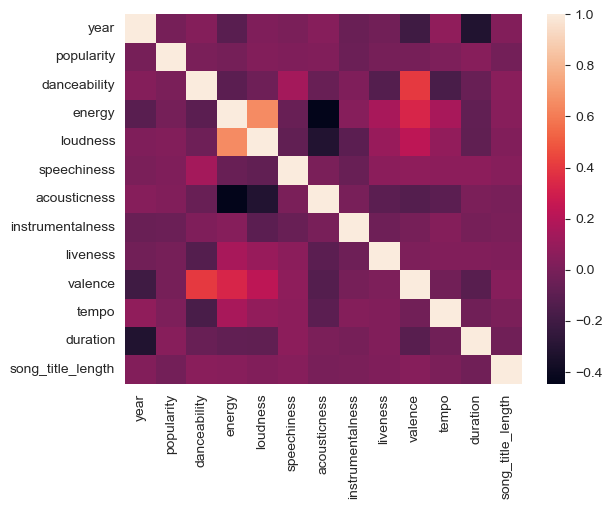

In [18]:
sns.heatmap(df.loc[:, df.columns.isin(numeric_columns)].corr(method="pearson",))
plt.show()

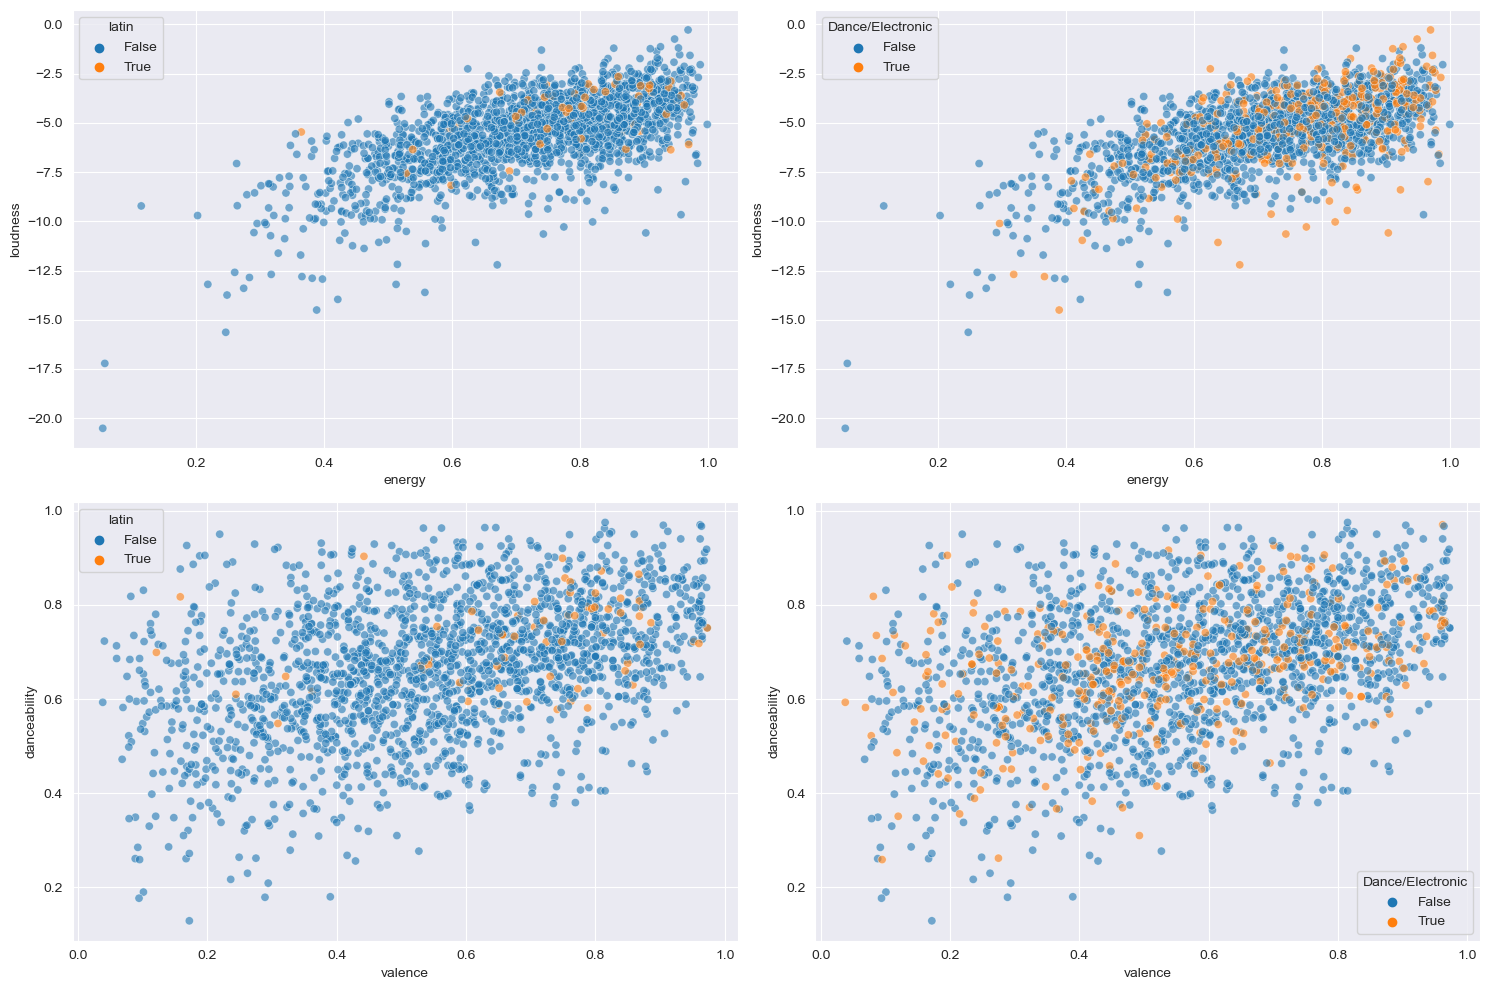

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(data=df, x="energy", y="loudness", hue="latin", ax=ax[0, 0], alpha=0.6)
sns.scatterplot(data=df, x="energy", y="loudness", hue="Dance/Electronic", ax=ax[0, 1], alpha=0.6)
sns.scatterplot(data=df, x="valence", y="danceability", hue="latin", ax=ax[1, 0], alpha=0.6)
sns.scatterplot(data=df, x="valence", y="danceability", hue="Dance/Electronic", ax=ax[1, 1], alpha=0.6)
plt.tight_layout()
plt.show()

In [378]:
df[numeric_columns].describe()

,year,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,song_title_length
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,2009.520350,59.633179,0.667814,0.721549,-5.514082,0.103783,0.128173,0.015372,0.181726,0.552966,120.158442,3.809916,17.719732
std,5.875532,21.501053,0.140608,0.152872,1.938950,0.096148,0.172584,0.088371,0.140910,0.220845,26.990475,0.654163,12.293103
min,1998.000000,0.000000,0.129000,0.054900,-20.514000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000,1.883333,1.000000
25%,2004.000000,56.000000,0.581000,0.624000,-6.490000,0.039700,0.013500,0.000000,0.088400,0.390000,98.986000,3.391767,9.000000
50%,2010.000000,65.000000,0.676000,0.739000,-5.285000,0.061000,0.055800,0.000000,0.124000,0.560000,120.028000,3.719767,14.000000
75%,2015.000000,73.000000,0.765000,0.840000,-4.168000,0.129000,0.176000,0.000069,0.242000,0.731000,134.199000,4.132433,23.000000
max,2020.000000,89.000000,0.975000,0.999000,-0.276000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000,8.069100,114.000000


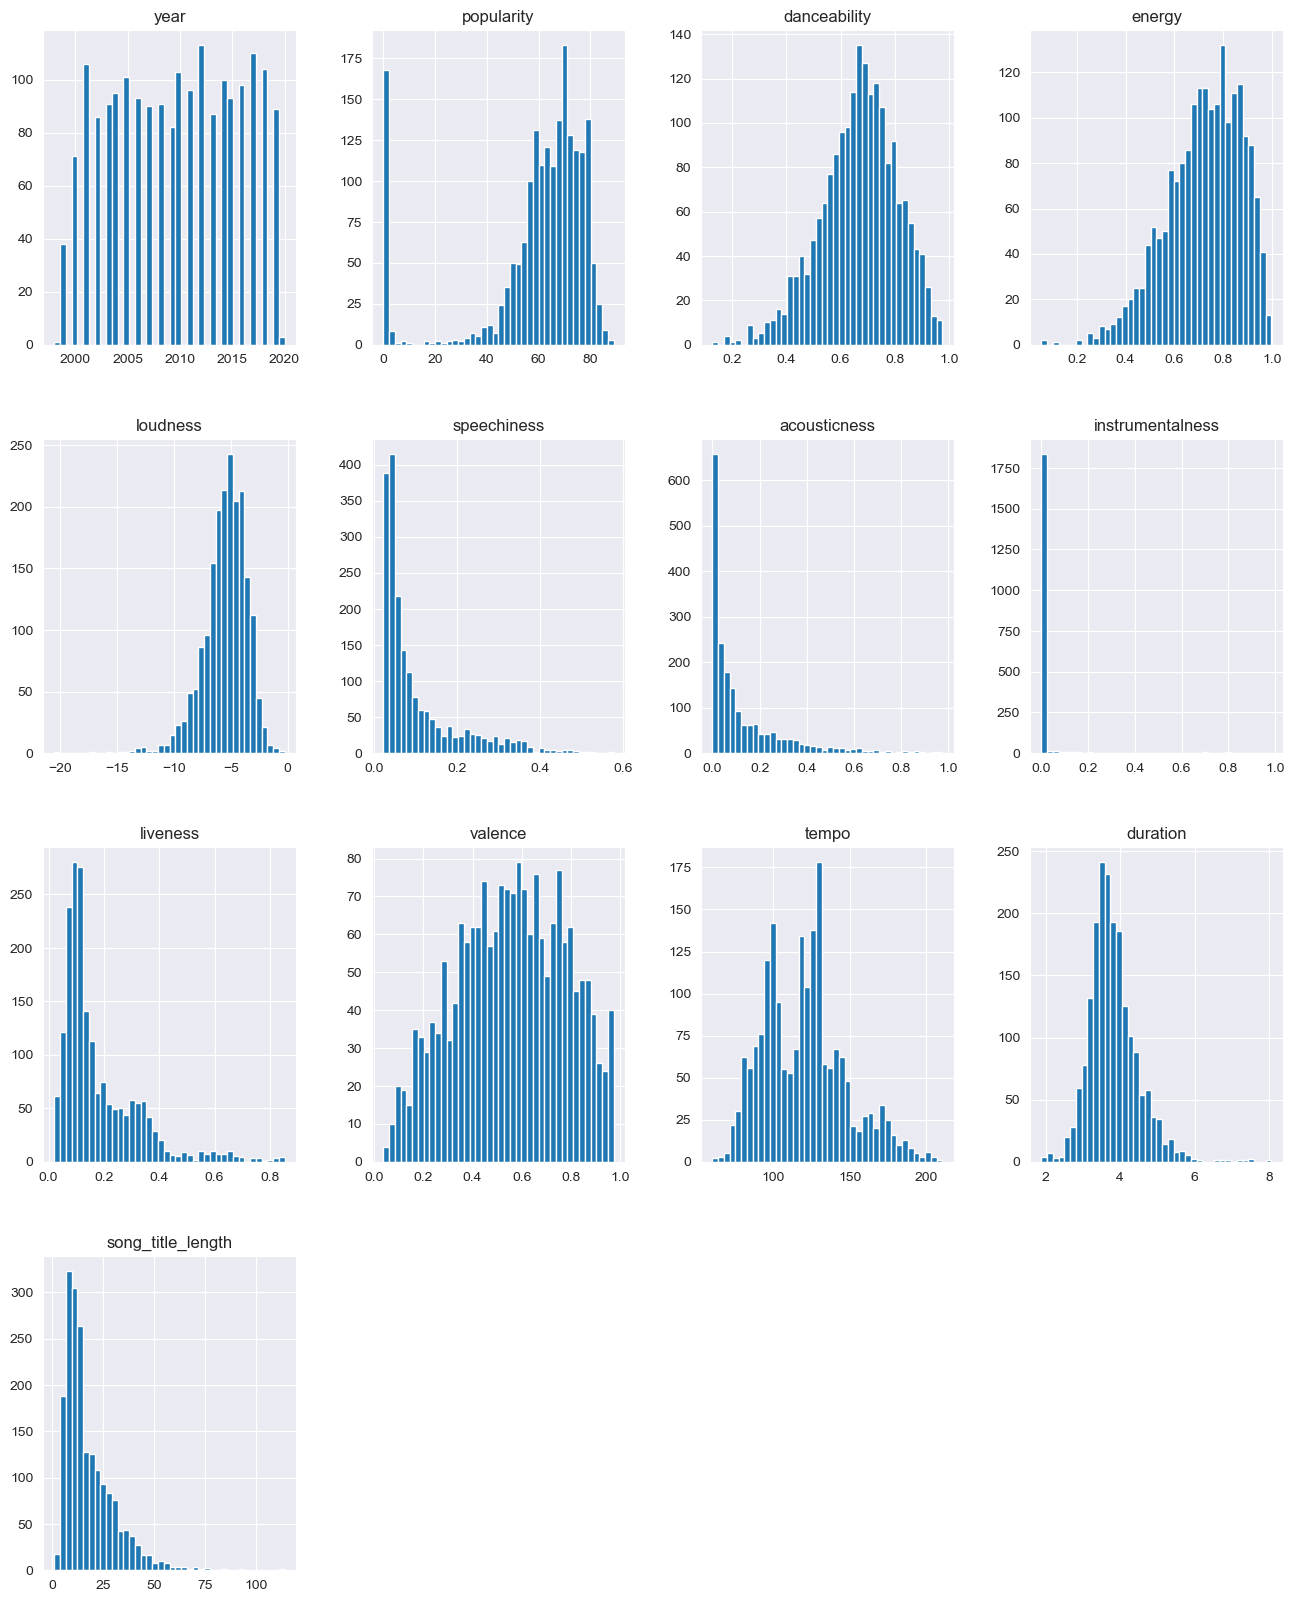

In [544]:
df[numeric_columns].hist(figsize=(16, 20), bins=40)
plt.show()

In [560]:
grouped_by_year = df.groupby("year").agg(["mean", "median", "std"]).reset_index(level=0)
grouped_by_year

year  explicit                  popularity                   danceability  \
              mean median       std       mean median        std         mean   
0   1998  1.000000    1.0       NaN  49.000000   49.0        NaN     0.727000   
1   1999  0.210526    0.0  0.413155  64.921053   64.0   7.627764     0.668974   
2   2000  0.169014    0.0  0.377432  58.239437   58.0  17.180940     0.690817   
3   2001  0.216981    0.0  0.414148  59.349057   61.0  13.499942     0.674698   
4   2002  0.325581    0.0  0.471340  62.104651   61.0  11.991202     0.674128   
5   2003  0.241758    0.0  0.430521  58.758242   61.0  14.487804     0.666033   
6   2004  0.368421    0.0  0.484935  58.631579   60.0  14.190237     0.694779   
7   2005  0.277228    0.0  0.449862  61.663366   65.0  17.711735     0.674020   
8   2006  0.279570    0.0  0.451220  57.161290   63.0  20.660975     0.663462   
9   2007  0.244444    0.0  0.432165  59.477778   62.0  17.909402     0.626589   
10  2008  0.230769    0.0  0.423659  63.208791   66.0  16.117290     0.667505   
11  2009  0.268293    0.0  0.445797  62.024390   65.0  15.842571     0.623915   
12  2010  0.223301    0.0  0.418495  60.524272   66.0  20.725018     0.660417   
13  2011  0.260417    0.0  0.441166  58.062500   67.0  24.452236     0.634531   
14  2012  0.168142    0.0  0.375658  60.203540   67.0  23.595611     0.636257   
15  2013  0.218391    0.0  0.415549  54.551724   65.0  27.885463     0.632667   
16  2014  0.190000    0.0  0.394277  58.970000   68.0  26.019594     0.666670   
17  2015  0.301075    0.0  0.461212  56.741935   70.0  28.721641     0.650538   
18  2016  0.316327    0.0  0.467433  53.948980   67.0  29.660753     0.668510   
19  2017  0.336364    0.0  0.474627  53.845455   67.5  30.710601     0.693482   
20  2018  0.471154    0.0  0.501584  70.519231   73.0  15.752935     0.728019   
21  2019  0.415730    0.0  0.495640  63.011236   71.0  22.904195     0.719764   
22  2020  0.666667    1.0  0.577350  43.333333   39.0  12.096832     0.745333   

                      ...     latin     metal                   \
    median       std  ...       std      mean median       std   
0   0.7270       NaN  ...       NaN  0.000000    0.0       NaN   
1   0.6860  0.144164  ...  0.273276  0.078947    0.0  0.273276   
2   0.7080  0.131179  ...  0.202599  0.098592    0.0  0.300235   
3   0.6795  0.147639  ...  0.166622  0.075472    0.0  0.265406   
4   0.6940  0.136881  ...  0.000000  0.058140    0.0  0.235380   
5   0.6630  0.153954  ...  0.147424  0.131868    0.0  0.340222   
6   0.7060  0.141264  ...  0.144321  0.010526    0.0  0.102598   
7   0.6780  0.169362  ...  0.170613  0.049505    0.0  0.218002   
8   0.6870  0.173415  ...  0.177642  0.010753    0.0  0.103695   
9   0.6385  0.148205  ...  0.148231  0.055556    0.0  0.230345   
10  0.6740  0.127826  ...  0.104828  0.065934    0.0  0.249542   
11  0.6305  0.159903  ...  0.188897  0.024390    0.0  0.155207   
12  0.6750  0.115829  ...  0.138662  0.000000    0.0  0.000000   
13  0.6450  0.123291  ...  0.200875  0.020833    0.0  0.143576   
14  0.6580  0.124234  ...  0.185607  0.017699    0.0  0.132443   
15  0.6470  0.114404  ...  0.000000  0.000000    0.0  0.000000   
16  0.6745  0.129170  ...  0.171447  0.000000    0.0  0.000000   
17  0.6670  0.145728  ...  0.000000  0.021505    0.0  0.145848   
18  0.6715  0.129200  ...  0.101015  0.010204    0.0  0.101015   
19  0.7005  0.131373  ...  0.245221  0.000000    0.0  0.000000   
20  0.7385  0.126570  ...  0.282519  0.000000    0.0  0.000000   
21  0.7400  0.124389  ...  0.287641  0.022472    0.0  0.149052   
22  0.8360  0.189985  ...  0.000000  0.000000    0.0  0.000000   

   World/Traditional                  Dance/Electronic                   
                mean median       std             mean median       std  
0           0.000000    0.0       NaN         0.000000    0.0       NaN  
1           0.000000    0.0  0.000000         0.078947    0.0  0.273276  
2           0.014085    0.0  0.

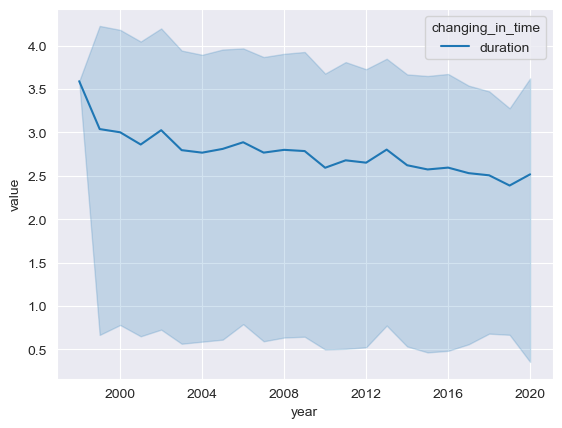

In [570]:
melted = grouped_by_year.melt("year", var_name="changing_in_time")
melted.year = pd.to_datetime(melted.year, format="%Y")

subset = melted[melted.changing_in_time.isin(["duration", "song_title_length"])]

sns.lineplot(data=subset, x="year", y="value", hue="changing_in_time")
plt.show()

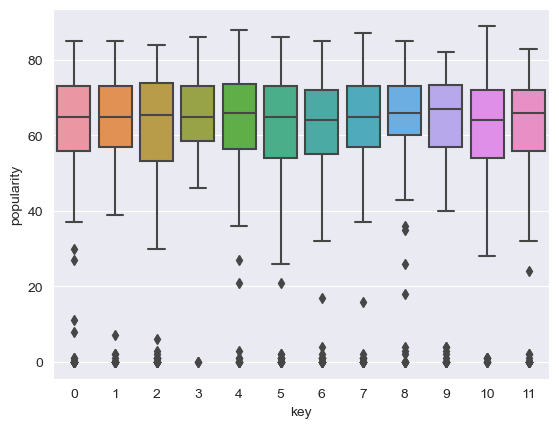

In [380]:
sns.boxplot(data=df, x="key", y="popularity")
plt.show()

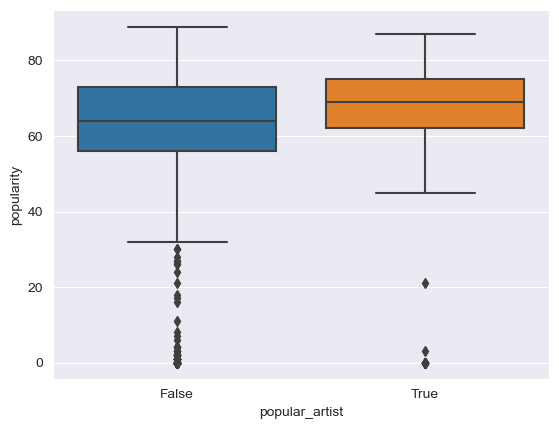

In [388]:
sns.boxplot(data=df, x="popular_artist", y="popularity")
plt.show()

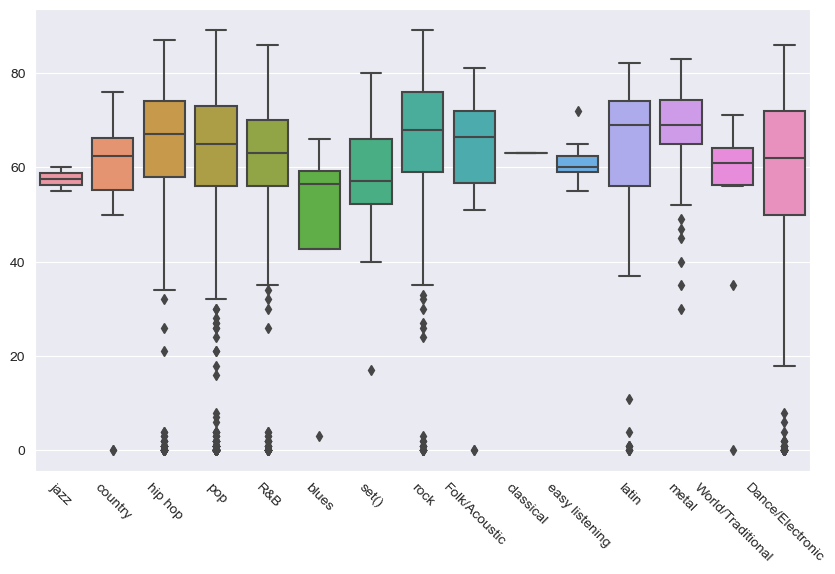

In [442]:
genres_popularity = []

for genre in unique_genres:
    genres_popularity.append(df[df[genre] == True]["popularity"].to_list())

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=genres_popularity)
plt.xticks(list(range(15)), unique_genres, rotation=-45)
plt.show()

In [21]:
df[df["popularity"] == df["popularity"].max()]

,artist,song,explicit,year,popularity,danceability,energy,key,loudness,mode,...,R&B,rock,latin,country,easy listening,Dance/Electronic,classical,set(),jazz,World/Traditional
1322,The Neighbourhood,Sweater Weather,False,2013,89,0.612,0.807,10,-2.81,True,...,False,True,False,False,False,False,False,False,False,False


In [25]:
df[df["loudness"] < -16]

,artist,song,explicit,year,popularity,danceability,energy,key,loudness,mode,...,R&B,rock,latin,country,easy listening,Dance/Electronic,classical,set(),jazz,World/Traditional
496,Gary Jules,Mad World (Feat. Michael Andrews),False,2001,65,0.345,0.0581,3,-17.217,True,...,False,False,False,False,False,False,False,False,False,False
1492,Ed Sheeran,"I See Fire - From ""The Hobbit - The Desolation...",False,2013,71,0.581,0.0549,10,-20.514,False,...,False,False,False,False,False,False,False,False,False,False
